In [7]:
import os
import cv2
import argparse
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator

  
import os
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
import shutil

physical_devices = tf.config.list_physical_devices("GPU")
print("Num GPUs Available: ", physical_devices, len(tf.config.list_physical_devices('GPU')))
# tf.test.gpu_device_name()
device_lib.list_local_devices()

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)





Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] 1
Physical devices cannot be modified after being initialized


In [20]:
batch_size = 8
epochs = 5
lr_rate = 1e-3
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SHAPE = (224, 224, 3)
# model_saved_folder_path = 'model_saved\\'
# model_weight_path = 'weight\\'

# model_filepath1 = model_saved_folder_path + model_weight_path + "model-InceptionV3-{epoch:02d}-{val_accuracy:.4f}.h5"
# model_filepath2 = model_saved_folder_path + model_weight_path + "model-VGG16-{epoch:02d}-{val_accuracy:.4f}.h5"



data sort

In [2]:
import matplotlib.pyplot as plt
from tensorflow.keras import layers


initial_lr = 1e-3 # learning rate
# epochs = 40 # no of eopches to train
# batch_size = 32 # batch size 
img_size = 224

print("LOADING IMAGES.......")
imagePaths = list(paths.list_images("data"))
data = []
labels =[]


#loop for the image paths
for imagePath in imagePaths:
	#extract the class label from the file
	label = imagePath.split(os.path.sep)[-2]

	#load the image
	#swap color channels and resize it
	#fixed 224*224 pixels while ingorning aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (img_size, img_size))

	#update the data and labes lists
	data.append(image)
	labels.append(label)

print("original labels: ", labels[0])
print("original labels: ", labels[-1])
# print("original labels to binary: ",labels)

#convert the data and labels to numpay
#while scalling the pixel to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)


# performs one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

print("original labels to binary: ",labels[0])
print("original labels to binary: ",labels[-1])
# print("original labels to binary: ",labels)

# labels = to_categorical(labels)
# print("binary labels to category: ", labels[0])
# print("binary labels to category: ", labels[-1])
# print("binary labels to category: ", labels)

#partition the data for tranning(80%)
#and testing(20%) using splits
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

data_generator_with_aug = ImageDataGenerator(
#  rotation_range=45,
#  fill_mode="nearest", 
#  horizontal_flip=True, 
 width_shift_range = 0.1, 
 height_shift_range = 0.1, 
#  shear_range=16
)


# data_generator_with_aug = ImageDataGenerator()




# print(testX)
# data_generator_with_aug.fit(trainX)
# print(plt.imshow(trainX[0]))
# print(lb.classes_)

LOADING IMAGES.......
original labels:  covideff
original labels:  normaleff
original labels to binary:  [0]
original labels to binary:  [1]


function for creating, fitting the model and plot the result

In [3]:
from tensorflow.keras.callbacks import ModelCheckpoint

def create_model(baseModel):
    baseModel.trainable=False  # all base weight set to non-trainable
    #constructing the head of the model that will be placed
    #on the top of the model
    headModel = baseModel.output
    headModel = layers.GlobalAveragePooling2D()(headModel)
    # headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(1024, activation="relu")(headModel)
    headModel = Dropout(0.2)(headModel)
    # headModel = Dense(1, activation="sigmoid")(headModel)
    headModel = Dense(1, activation="sigmoid")(headModel)
    #place the head FC model on top of the base model
    #it will become the actual model will be train
    model = Model(inputs=baseModel.input, outputs=headModel)
    # #loop over all layers in the base model 
    # for layer in baseModel.layers:
    # 	layer.trainable = False
    #compile our model
    print("compiling model.....")
    opt = Adam(learning_rate=initial_lr, decay=initial_lr / epochs)
    model.compile(loss="binary_crossentropy", optimizer=opt,
        metrics=["accuracy"])
    return model

def fit_model(model,model_filepath):
    checkpoint = ModelCheckpoint(
                filepath=model_filepath,
                monitor = 'val_accuracy',
                mode='max',
                save_best_only=True,
                verbose=1
                )
    history = model.fit(
            trainX, trainY,
            batch_size=batch_size,
            steps_per_epoch=len(trainX) // batch_size,
            epochs=epochs,
            validation_data=(testX, testY),
            validation_steps=len(testX) // batch_size,
            callbacks=[checkpoint]
            )
    return history

# def plot_history(history):
#     acc = history.history['accuracy']
#     val_acc = history.history['val_accuracy']

#     loss=history.history['loss']
#     val_loss=history.history['val_loss']

#     epochs_range = range(epochs)

#     plt.figure(figsize=(12, 6))
#     plt.subplot(1, 2, 1)
#     plt.plot(epochs_range, acc, label='Training Accuracy')
#     plt.plot(epochs_range, val_acc, label='Validation Accuracy')
#     plt.legend(loc='lower right')
#     plt.title('Training and Validation Accuracy')

#     plt.subplot(1, 2, 2)
#     plt.plot(epochs_range, loss, label='Training Loss')
#     plt.plot(epochs_range, val_loss, label='Validation Loss')
#     plt.legend(loc='upper right')
#     plt.title('Training and Validation Loss')
#     plt.show()

In [8]:
base_model1 = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
base_model2 = tf.keras.applications.VGG16(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")

model1 = create_model(base_model1)
model2 = create_model(base_model2)

model_saved_folder_path = 'model_saved\\'
model_weight_path = 'weight\\'

model_filepath1 = model_saved_folder_path + model_weight_path + "model-InceptionV3-{epoch:02d}-{val_accuracy:.4f}.h5"
model_filepath2 = model_saved_folder_path + model_weight_path + "model-VGG16-{epoch:02d}-{val_accuracy:.4f}.h5"



compiling model.....
compiling model.....


In [12]:
model1.summary()
model2.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 111, 111, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 111, 111, 32) 0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

In [5]:


#train the head of the network
print("tranning head.........")
history1 = fit_model(model1, model_filepath1)
history2 = fit_model(model2, model_filepath2)

tranning head.........
Epoch 1/5
200/200 [==============================] - 13s 29ms/step - loss: 0.5942 - accuracy: 0.7812 - val_loss: 0.4755 - val_accuracy: 0.7625

Epoch 00001: val_accuracy improved from -inf to 0.76250, saving model to model_saved\weight\model-InceptionV3-01-0.7625.h5
Epoch 2/5
200/200 [==============================] - 5s 24ms/step - loss: 0.3090 - accuracy: 0.8712 - val_loss: 0.2759 - val_accuracy: 0.8875

Epoch 00002: val_accuracy improved from 0.76250 to 0.88750, saving model to model_saved\weight\model-InceptionV3-02-0.8875.h5
Epoch 3/5
200/200 [==============================] - 5s 24ms/step - loss: 0.2776 - accuracy: 0.8737 - val_loss: 0.2833 - val_accuracy: 0.8825

Epoch 00003: val_accuracy did not improve from 0.88750
Epoch 4/5
200/200 [==============================] - 5s 24ms/step - loss: 0.2618 - accuracy: 0.8969 - val_loss: 0.2771 - val_accuracy: 0.8825

Epoch 00004: val_accuracy did not improve from 0.88750
Epoch 5/5
200/200 [==========================

In [ ]:
plot_history(history1)
plot_history(history2)

In [14]:
def load_all_models(model_path_name):
    all_models = []
    # model_path_name = []
    model_names = model_path_name
    for model_name in model_names:
        filename = os.path.join(model_name)
        model = tf.keras.models.load_model(filename)
        all_models.append(model)
        print('loaded:', filename)
    return all_models


summary_path = 'model_saved_new\\ensemble\\'
model_name1 = summary_path+'model-Dense201-30-0.9533.h5'
model_name2 = summary_path+'model-InceptionV3-36-0.9308.h5'
model_name4 = summary_path+'model-Xception-19-0.9350.h5'
model_name3 = summary_path+'model-MobileV2-37-0.9600.h5'
model_name5 = summary_path+'model-VGG16-37-0.9375.h5'
# model_name6 = summary_path+'model-Res101-21-0.9542.h5'



models = load_all_models([model_name1,model_name2,model_name3,model_name4,model_name5])
print(models)

loaded: model_saved_new\ensemble\model-Dense201-30-0.9533.h5
loaded: model_saved_new\ensemble\model-InceptionV3-36-0.9308.h5
loaded: model_saved_new\ensemble\model-MobileV2-37-0.9600.h5
loaded: model_saved_new\ensemble\model-Xception-19-0.9350.h5
loaded: model_saved_new\ensemble\model-VGG16-37-0.9375.h5
[<tensorflow.python.keras.engine.functional.Functional object at 0x000001D2D4498F70>, <tensorflow.python.keras.engine.functional.Functional object at 0x000001D2D6FEE190>, <tensorflow.python.keras.engine.functional.Functional object at 0x000001D2D481BFA0>, <tensorflow.python.keras.engine.functional.Functional object at 0x000001D2D43C53A0>, <tensorflow.python.keras.engine.functional.Functional object at 0x000001D2D40EEF70>]


In [15]:
from tensorflow.keras import layers
def ensemble_model(models):
        # model1.summary()

    # models[0].layers[0]._name = models[0].layers[0]._name + "inc"
    # models[1].layers[0]._name = models[1].layers[0]._name + "inc"

    # for i, layer in enumerate(models[0].layers):
    #     layer._name = models[0].layers[i]._name + "_dense"
    # for i, layer in enumerate(models[1].layers):
    #     layer._name = models[1].layers[i]._name + "_inc"
    # for i, layer in enumerate(models[2].layers):
    #     layer._name = models[2].layers[i]._name + "_mob"
    # for i, layer in enumerate(models[3].layers):
    #     layer._name = models[3].layers[i]._name + "_xcep"
    # for i, layer in enumerate(models[4].layers):
    #     layer._name = models[4].layers[i]._name + "_vgg"

    for i, model in enumerate(models):
        for layer in model.layers:
            layer.trainable = False
            from tensorflow.keras import layers

    ensemble_visible = [model.input for model in models]
    ensemble_outputs = [model.output for model in models]
    merge = tf.keras.layers.concatenate(ensemble_outputs)
    merge = tf.keras.layers.Dense(10, activation='relu')(merge)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(merge)
    model = tf.keras.models.Model(inputs=ensemble_visible, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])
    return model

In [16]:
for i, layer in enumerate(models[0].layers):
    layer._name = models[0].layers[i]._name + "_dense"
for i, layer in enumerate(models[1].layers):
    layer._name = models[1].layers[i]._name + "_inc"
for i, layer in enumerate(models[2].layers):
    layer._name = models[2].layers[i]._name + "_mob"
for i, layer in enumerate(models[3].layers):
    layer._name = models[3].layers[i]._name + "_xcep"
for i, layer in enumerate(models[4].layers):
    layer._name = models[4].layers[i]._name + "_vgg"


# for i, layer in enumerate(models[0].layers):
#     layer._name = models[0].layers[i]._name + "_dense"
# for i, layer in enumerate(models[1].layers):
#     layer._name = models[1].layers[i]._name + "_inc"
# for i, layer in enumerate(models[2].layers):
#     layer._name = models[2].layers[i]._name + "_mob"
# for i, layer in enumerate(models[3].layers):
#     layer._name = models[3].layers[i]._name + "_xcep"
# for i, layer in enumerate(models[4].layers):
#     layer._name = models[4].layers[i]._name + "_vgg"
# for i, layer in enumerate(models[5].layers):
#     layer._name = models[5].layers[i]._name + "_res"  

# models[0].summary()
# models[1].summary()
# models[2].summary()
# models[3].summary()
# models[4].summary()

In [17]:
# model_used = ['InceptionV3', 'VGG16']
# model_best_acc = ['-02-0.8875','-05-0.9100']

# model_weight_loaded1 =  model_saved_folder_path + model_weight_path + 'model-' + model_used[0] + model_best_acc[0] + '.h5'
# model_weight_loaded2 =  model_saved_folder_path + model_weight_path + 'model-' + model_used[1] + model_best_acc[1] + '.h5'
# model_weight_name =[model_weight_loaded1,model_weight_loaded2]

# print(model_weight_name)

# models = load_all_models(model_weight_name)
# models.summary()
model = ensemble_model(models)
model.summary()
model.save(summary_path + 'model_ensemble5.h5')




c:\Users\User\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
c:\Users\User\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_dense (InputLayer)      [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_dense (ZeroPaddi (None, 230, 230, 3)  0           input_1_dense[0][0]              
__________________________________________________________________________________________________
conv1/conv_dense (Conv2D)       (None, 112, 112, 64) 9408        zero_padding2d_dense[0][0]       
__________________________________________________________________________________________________
conv1/bn_dense (BatchNormalizat (None, 112, 112, 64) 256         conv1/conv_dense[0][0]           
____________________________________________________________________________________________

In [8]:
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
summary_path = 'model_saved_new\\ensemble\\'
model = load_model(summary_path + 'model_ensemble.h5')

In [5]:
result_path  = ''
model_name = 'model-Dense201-30-0.9533'

testY = np.load(summary_path +result_path + 'testY_' + model_name + '.npy')
trainY = np.load(summary_path +result_path + 'trainY_' + model_name + '.npy')
testX= np.load(summary_path +result_path + 'testX_' + model_name + '.npy')
trainX = np.load(summary_path +result_path + 'trainX_' + model_name + '.npy')


In [6]:
X = [trainX for _ in range(len(model.input))]
X_1 = [testX for _ in range(len(model.input))]

In [7]:
batch_size = 8
epochs = 5
lr_rate = 1e-3
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SHAPE = (224, 224, 3)

In [10]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

start from here before saving np


In [19]:
import matplotlib.pyplot as plt
from tensorflow.keras import layers


initial_lr = 1e-3 # learning rate
epochs = 40 # no of eopches to train
batch_size = 32 # batch size 
img_size = 224

print("LOADING IMAGES.......")
imagePaths = list(paths.list_images("data1"))
data = []
labels =[]


#loop for the image paths
for imagePath in imagePaths:
	#extract the class label from the file
	label = imagePath.split(os.path.sep)[-2]

	#load the image
	#swap color channels and resize it
	#fixed 224*224 pixels while ingorning aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (img_size, img_size))

	#update the data and labes lists
	data.append(image)
	labels.append(label)

print("original labels: ", labels[0])
print("original labels: ", labels[-1])
# print("original labels to binary: ",labels)

#convert the data and labels to numpay
#while scalling the pixel to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)


# performs one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

print("original labels to binary: ",labels[0])
print("original labels to binary: ",labels[-1])
# print("original labels to binary: ",labels)


#partition the data for tranning(80%)
#and testing(20%) using splits
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

data_generator_with_aug = ImageDataGenerator(
#  rotation_range=45,
#  fill_mode="nearest", 
#  horizontal_flip=True, 
 width_shift_range = 0.1, 
 height_shift_range = 0.1, 
#  shear_range=16
)


# data_generator_with_aug = ImageDataGenerator()




# print(testX)
# data_generator_with_aug.fit(trainX)
# print(plt.imshow(trainX[0]))
# print(lb.classes_)


import pandas as pd
import numpy as np

model_name =  'model-ensemble'
summary_path = 'model_saved_new\\ensemble\\'


# print(testY.argmax(axis=1))
# print(testY)
np.save(summary_path +'testY_' + model_name + '.npy', testY)
np.save(summary_path +'trainY_' + model_name + '.npy', trainY)
np.save(summary_path +'testX_' + model_name + '.npy', testX)
np.save(summary_path +'trainX_' + model_name + '.npy', trainX)

LOADING IMAGES.......
original labels:  covideff
original labels:  normaleff
original labels to binary:  [0]
original labels to binary:  [1]


**start from here after saving np**


In [1]:
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
summary_path = 'model_saved_new\\ensemble\\'
model = load_model(summary_path + 'model_ensemble4.h5')

In [2]:

import pandas as pd
import numpy as np

result_path  = ''
model_name = 'model-ensemble'

testY = np.load(summary_path +result_path + 'testY_' + model_name + '.npy')
trainY = np.load(summary_path +result_path + 'trainY_' + model_name + '.npy')
testX= np.load(summary_path +result_path + 'testX_' + model_name + '.npy')
trainX = np.load(summary_path +result_path + 'trainX_' + model_name + '.npy')

In [3]:
X = [trainX for _ in range(len(model.input))]
X_1 = [testX for _ in range(len(model.input))]

In [14]:
print(len(model.input))

4


In [4]:
xx = len(trainX)
xxx = len(testX)
del trainX
del testX

print(xx)


1600


In [5]:
batch_size = 8
epochs = 40
lr_rate = 1e-3
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SHAPE = (224, 224, 3)

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_filepath = summary_path + "model-ensemble4-{epoch:02d}-{val_accuracy:.4f}.h5"

checkpoint = ModelCheckpoint(
            filepath=model_filepath,
            monitor = 'val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
            )
history = model.fit(
        X, trainY,
        batch_size=batch_size,
        steps_per_epoch=xx // batch_size,
        epochs=epochs,
        validation_data=(X_1, testY),
        validation_steps=xxx // batch_size,
        callbacks=[checkpoint])

Epoch 1/40


c:\Users\User\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\backend.py:5029: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


200/200 [==============================] - 46s 138ms/step - loss: 0.5819 - accuracy: 0.9206 - val_loss: 0.4484 - val_accuracy: 0.9775

Epoch 00001: val_accuracy improved from -inf to 0.97750, saving model to model_saved_new\ensemble\model-ensemble4-01-0.9775.h5


c:\Users\User\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/40
200/200 [==============================] - 23s 117ms/step - loss: 0.3240 - accuracy: 0.9775 - val_loss: 0.2120 - val_accuracy: 0.9825

Epoch 00002: val_accuracy improved from 0.97750 to 0.98250, saving model to model_saved_new\ensemble\model-ensemble4-02-0.9825.h5
Epoch 3/40
200/200 [==============================] - 23s 117ms/step - loss: 0.1577 - accuracy: 0.9844 - val_loss: 0.1105 - val_accuracy: 0.9900

Epoch 00003: val_accuracy improved from 0.98250 to 0.99000, saving model to model_saved_new\ensemble\model-ensemble4-03-0.9900.h5
Epoch 4/40
200/200 [==============================] - 23s 117ms/step - loss: 0.0921 - accuracy: 0.9869 - val_loss: 0.0708 - val_accuracy: 0.9900

Epoch 00004: val_accuracy did not improve from 0.99000
Epoch 5/40
200/200 [==============================] - 23s 117ms/step - loss: 0.0645 - accuracy: 0.9887 - val_loss: 0.0531 - val_accuracy: 0.9900

Epoch 00005: val_accuracy did not improve from 0.99000
Epoch 6/40
200/200 [==========================

In [9]:
import pandas as pd
import numpy as np

summary_path = 'model_saved_new\\ensemble\\output\\'

model_name =  'model-ensemble4-03-0.9900'

# # # print(testY.argmax(axis=1))
# # # print(testY)
# np.save(summary_path +'testY_' + model_name + '.npy', testY)
# np.save(summary_path +'trainY_' + model_name + '.npy', trainY)
# np.save(summary_path +'testX_' + model_name + '.npy', testX)
# np.save(summary_path +'trainX_' + model_name + '.npy', trainX)

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = summary_path +model_name + '_history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)
# or save to csv: 
hist_csv_file = summary_path +model_name + '_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)



***Evaulation***

evaluating network.....
True positive =  198
True negative =  198
False positive =  2
False negative =  2
[[198   2]
 [  2 198]]
accurancy: 0.9900
precision: 0.9900
sensitivity: 0.9900
specificity: 0.9900
f1-score: 0.9900
NPV: 0.9900


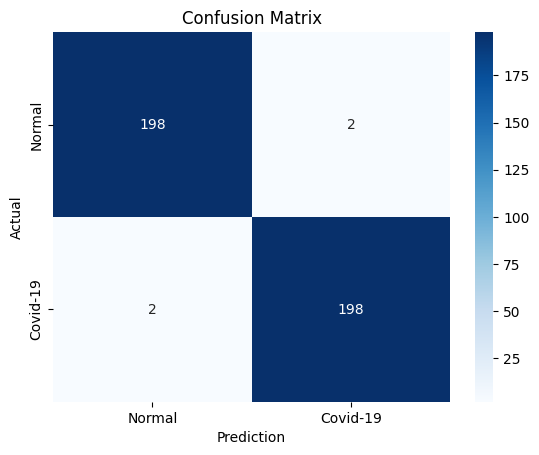

C:\Users\User\AppData\Local\Temp\ipykernel_8500\1383397594.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  history_df['epochs'][i]=int(history_df['epochs'][i])+1


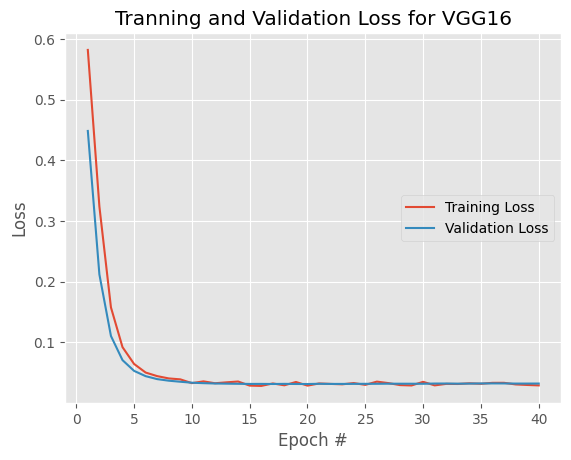

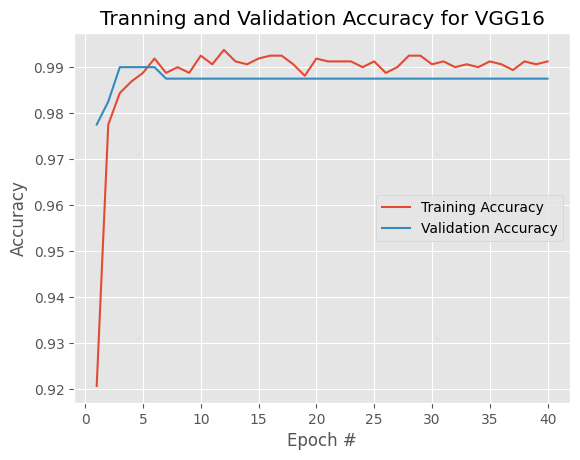

In [3]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# testX_data= X_1
# trainX_data =X

batch_size = 8

# result_path  = ''

summary_path = 'model_saved_new\\ensemble\\'

# result_path use this to store different condition
result_path  = ''
model_name = 'model-ensemble4-03-0.9900'
model_name_data = 'model-ensemble'

# testX_data =testX
# testY_data =testY
testY_data = np.load(summary_path +result_path + 'testY_' + model_name_data + '.npy')
trainY_data = np.load(summary_path +result_path + 'trainY_' + model_name_data + '.npy')
testX_data = np.load(summary_path +result_path + 'testX_' + model_name_data + '.npy')
trainX_data = np.load(summary_path +result_path + 'trainX_' + model_name_data + '.npy')




# # convert the history.history dict to a pandas DataFrame:     
# hist_df = pd.DataFrame(history.history) 



model = load_model(summary_path +result_path + model_name + '.h5')


X = [trainX_data for _ in range(len(model.input))]
X_1 = [testX_data for _ in range(len(model.input))]

trainX_data = X
testX_data = X_1
# make predications on the testing set
print("evaluating network.....")
predIdxs = model.predict(testX_data, batch_size=batch_size)

threshold = 0.5

# Convert predicted probabilities to binary values using threshold
predIdxs = (predIdxs > threshold).astype(int)

# print(predIdxs)
# print(testY_data)
# for each image in the testing set we need 
# to find the the index of the label with 
# corresponding largest predicated probability

# predIdxs = np.argmax(predIdxs, axis=1)
# testY original is [1. 0.] testY.argmax(axis=1) let 
# [1. 0.] become 0
# [0. 1.] become 1

# import pandas as pd
# # convert the history.history dict to a pandas DataFrame:     
# hist_df = pd.DataFrame(history.history) 

# # save to json:  
# hist_json_file = model_name + '_history.json' 
# with open(hist_json_file, mode='w') as f:
#     hist_df.to_json(f)

# # or save to csv: 
# hist_csv_file = model_name + '_history.csv'
# with open(hist_csv_file, mode='w') as f:
#     hist_df.to_csv(f)

# show a nicely formatted classification report

# print(classification_report(testY.argmax(axis=1), predIdxs,
# 	target_names=lb.classes_))

### lb.classes_ = covideff normaleff


#### for confusion matrix
# compute the confusion matrix nad use it 
# to drive the raw accuracy, sensitivity 
# and specificity
# cm = confusion_matrix(testY_data.argmax(axis=1), predIdxs)

cm = confusion_matrix(testY_data, predIdxs)

tp = cm[1,1]
tn = cm[0,0]
fp = cm[0,1]
fn = cm[1,0]

print('True positive = ', tp)
print('True negative = ', tn)
print('False positive = ', fp)
print('False negative = ', fn)

total_test = sum(sum(cm))
accurancy = (cm[0, 0] + cm[1, 1]) / total_test	### Accuracy (all correct / all) = TP + TN / TP + TN + FP + FN
precision = cm[0, 0] / (cm[0, 0] + cm[0, 1])
sensitivity = cm[0, 0] / (cm[0, 0] + cm[1, 0])	### Sensitivity aka Recall (true positives / all actual positives) = TP / TP + FN
specificity = cm[1, 1] / (cm[1, 1] + cm[0, 1])	### Specificity (true negatives / all actual negatives) =TN / TN + FP
f1score = 2*(precision*sensitivity)/(precision+sensitivity)
npv = tn/(tn+fn)

# show the cnfusion matrix, accuracy with 4 digits
#sensitivity, and specificity
print(cm)
print("accurancy: {:.4f}".format(accurancy))
print("precision: {:.4f}".format(precision))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))
print("f1-score: {:.4f}".format(f1score))
print("NPV: {:.4f}".format(npv))


import seaborn as sns
### fmt ='g' to turn off scientific number 
sns.heatmap(cm, cmap="Blues",annot=True, fmt='g',xticklabels=["Normal", "Covid-19"], yticklabels=["Normal", "Covid-19"])
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()


#### for loss and accuracy curve
import matplotlib.pyplot as plt
import json
import pandas as pd

model_history_json_name = summary_path +  result_path + model_name + '_history.json'
history_json = json.load(open(model_history_json_name, 'r'))
history_df=pd.DataFrame(history_json)
history_df=history_df.reset_index()
history_df.columns.values[0]='epochs'


for i in range(len(history_df['epochs'])):
    history_df['epochs'][i]=int(history_df['epochs'][i])+1


def annot_max(x,y, ax=None):
    maxIxVal = np.argmax(y);
    zeroBasedIx = np.argwhere(y.index==maxIxVal).flatten()[0];
    xmax = x[zeroBasedIx];
    ymax = y.max()
    text= "k={:d}, measure={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="-",connectionstyle="arc3,rad=0.1")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.90), **kw)

def annot_min(x,y, ax=None):
    minIxVal = np.argmin(y);
    zeroBasedIx = np.argwhere(y.index==minIxVal).flatten()[0];
    xmin = x[zeroBasedIx];
    ymin = y.min()
    text= "k={:d}, measure={:.3f}".format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="-",connectionstyle="arc3,rad=0.1")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmin, ymin), xytext=(0.94,0.90), **kw)


plt.style.use("ggplot")
plt.figure()
plt.plot()
plt.plot(history_df['epochs'],history_df['loss'],label='Training Loss')
plt.plot(history_df['epochs'],history_df['val_loss'],label='Validation Loss')
plt.legend(loc="center right")
plt.title("Tranning and Validation Loss for VGG16")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
# annot_max(history_df['epochs'],history_df['loss'])
plt.show()

plt.figure()
plt.plot()
plt.plot(history_df['epochs'],history_df['accuracy'],label='Training Accuracy')
plt.plot(history_df['epochs'],history_df['val_accuracy'],label='Validation Accuracy')
plt.legend(loc="center right")
plt.title("Tranning and Validation Accuracy for VGG16")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
# annot_max(history_df['epochs'],history_df['accuracy'])
# annot_max(history_df['epochs'],history_df['val_accuracy'])
plt.show()



#fn here: actual is 0(covideff) but identify to 1(normalleff) 0-->1: 7 0-->0:73
# for current confusion matrix become:
# original labels:  covideff
# original labels:  normaleff
# original labels to binary:  [0]
# original labels to binary:  [1]
# binary labels to category:  [1. 0.]
# binary labels to category:  [0. 1.]
# normaleff:	tn fp
# covideff:	fn tp


## confusion matrix (normally online is like below, my diff with online)
## tp fp
## fn tn

### Accuracy (all correct / all) = TP + TN / TP + TN + FP + FN
### Misclassification (all incorrect / all) = FP + FN / TP + TN + FP + FN
### Precision (true positives / predicted positives) = TP / TP + FP
### Sensitivity aka Recall (true positives / all actual positives) = TP / TP + FN
### Specificity (true negatives / all actual negatives) =TN / TN + FP




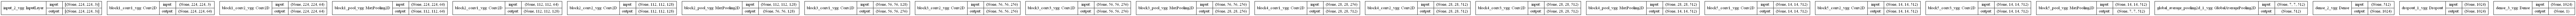

In [7]:
from tensorflow.keras.utils import plot_model
# from keras.utils import vis_utils
import os

model1 = models[0]
model2 = models[1]

summary_save_path = 'model_summary/'
### create file here need to manual create folder at window explorer

plot_model(model,to_file= summary_save_path + 'model_ensemble_plot.png' , show_shapes=True)
plot_model(model1, to_file= summary_save_path + 'model_1_plot.png', show_shapes=True, show_layer_names=True)
plot_model(model2, to_file= summary_save_path + 'model_2_plot.png', show_shapes=True, show_layer_names=True)

# model1.summary()
# model2.summary()
# model.summary()

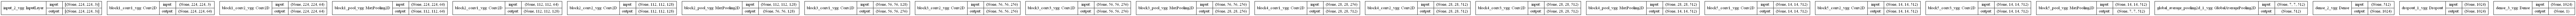

In [13]:
from tensorflow.keras.utils import plot_model
# from keras.utils import vis_utils
import os

model1 = models[0]
model2 = models[1]

summary_save_path = 'model_summary/'
### create file here need to manual create folder at window explorer

plot_model(model,to_file= summary_save_path + 'model_ensemble_plot.png' , show_shapes=True, show_layer_names=True)
plot_model(model1, to_file= summary_save_path + 'model_1_plot.png', show_shapes=True, show_layer_names=True)
plot_model(model2, to_file= summary_save_path + 'model_2_plot.png', show_shapes=True, show_layer_names=True)

# model1.summary()
# model2.summary()
# model.summary()